In [1]:
%matplotlib widget
import pandas as pd
from urllib.parse import quote
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import quaternion
# from ipywidgets import *
import ipywidgets as widgets
from scipy.interpolate import *


In [2]:
window_micros = 200 * 1e6

startTs = 1705169091376222
endTs = startTs + window_micros

session = "[2023-12-09T04:14:00.672Z::854]"


def download_data(device: str):
    url = f"https://csiwiki.me.columbia.edu/rocketsdata2/export/0/{quote(session)}/{device}/records?startTs={startTs}&endTs={endTs}"
    return pd.read_csv(url)


mpu = download_data("MPU")
dht = download_data("DHT")

print("\nMPU:")
print(mpu.head())

print("\nDHT:")
print(dht.head())



MPU:
                 ts    ax   ay  az  gx  gy  gz        ts.1
0  1705169091395662 -1985  136  31 -54   7   5  7674891678
1  1705169091396241 -1986  144  24 -50   8   7  7674893620
2  1705169091396803 -1986  137  16 -56  12   6  7674895564
3  1705169091397360 -1983  135  16 -51   6   3  7674897508
4  1705169091397910 -1981  138  18 -47  12   1  7674899453

DHT:
                 ts        ts.1  hum       temp
0  1705169092012521  7675497530    0  38.200001
1  1705169093053591  7676525439    0  38.200001
2  1705169094073497  7677553524    0  38.200001
3  1705169095093804  7678581439    0  38.200001
4  1705169096126057  7679609529    0  38.299999


In [3]:
i_final = 0
for i,ax in enumerate(mpu['ax']):
    if abs(ax) > 24000:
        i_final = i
        break
i_final -= 10 #7800

g_glb = 9.81

az = - mpu["ax"][:i_final] / 2048 * g_glb
ay = mpu["ay"][:i_final] / 2048 * g_glb
ax = mpu["az"][:i_final] / 2048 * g_glb
gz = - mpu["gx"][:i_final] / 16 * (np.pi / 180)
gy = mpu["gy"][:i_final] / 16 * (np.pi / 180)
gx = mpu["gz"][:i_final] / 16 * (np.pi / 180)
t = (mpu["ts"][:i_final]-mpu["ts"][0]) / 1e6

i_0 = 1400
a_0 = np.array([ax[:i_0], ay[:i_0], az[:i_0]]).transpose().mean(axis=0)
print(a_0)
a_0x, a_0y, a_0z = a_0
a_0xz = np.sqrt(a_0x**2 + a_0z**2)
a_0yz = np.sqrt(a_0y**2 + a_0z**2)
X = np.arcsin(a_0y/a_0yz) 
Y = -np.arccos(a_0z/a_0xz)
g_loc = np.sqrt(a_0x**2 + a_0y**2 + a_0z**2)

SDS_array = []
dt = []
for i in range(1, i_final):
    SDS_row = [np.array([ax[i], ay[i], az[i]]), np.array([gx[i], gy[i], gz[i]])]
    dt_row = (mpu["ts"][i] - mpu["ts"][i-1])/1e6
    SDS_array.append(SDS_row)
    dt.append(dt_row)


[4.18101981e-03 7.28852344e-01 9.50179520e+00]


18.611716


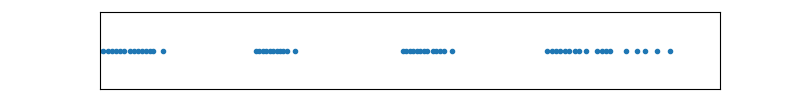

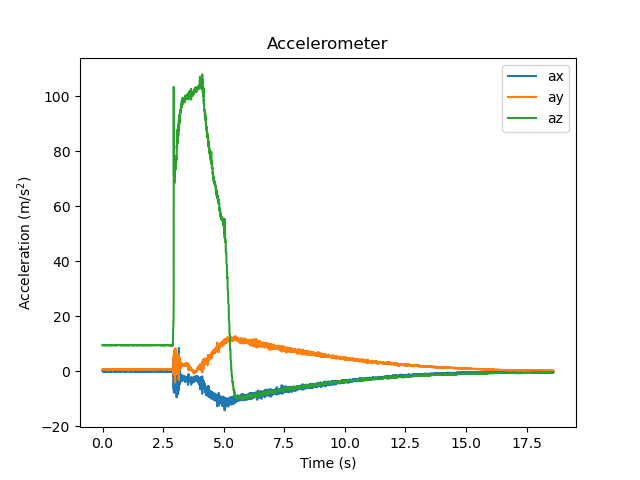

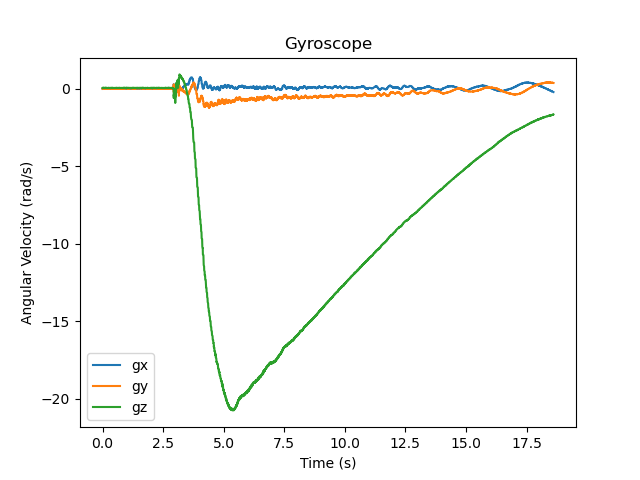

In [4]:
plt.figure(figsize=(8, 1))
plt.plot(t,np.zeros(len(t)),'.')
plt.xticks([])
plt.yticks([])
plt.ylim(-1e-6,1e-6)
plt.xlim(.05,.15)

plt.figure()
plt.plot(t,ax, label='ax')
plt.plot(t,ay, label='ay')
plt.plot(t,az, label='az')
plt.legend()
plt.title('Accelerometer')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration (m/s$^2$)')

plt.figure()
plt.plot(t,gx, label='gx')
plt.plot(t,gy, label='gy')
plt.plot(t,gz, label='gz')
plt.legend()
plt.title('Gyroscope')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')

print(list(t)[-1])


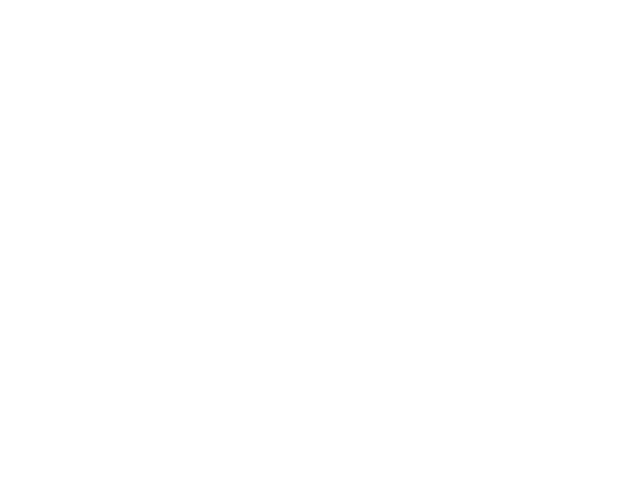

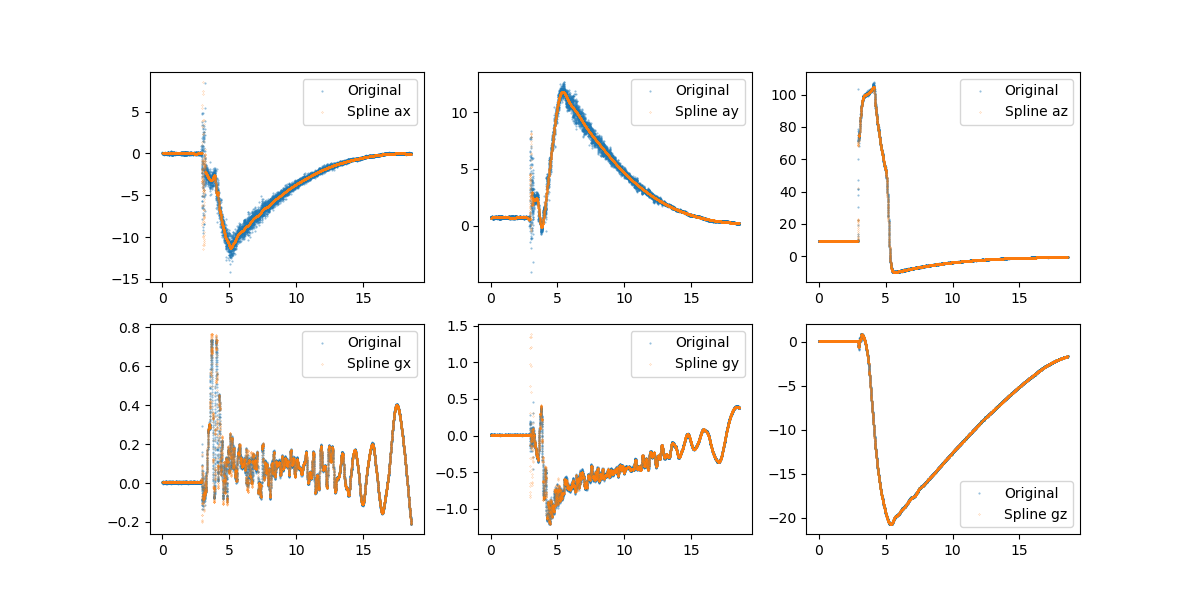

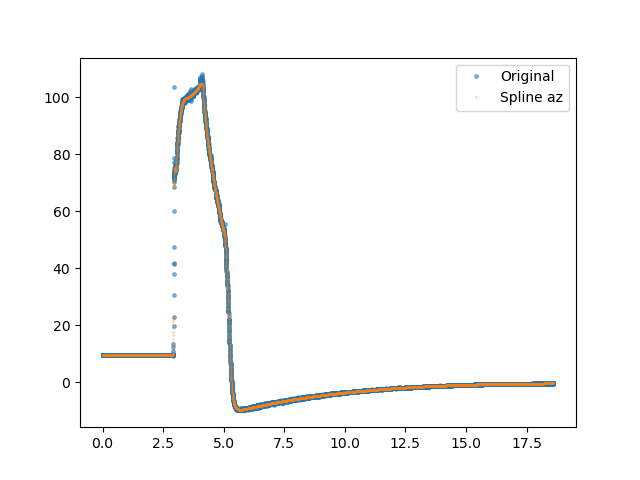

In [6]:
fine_t = np.arange(0, 18.611716, .002)

spline_ax = UnivariateSpline(t, ax, s=2000)
spline_ay = UnivariateSpline(t, ay, s=1200)
spline_az = UnivariateSpline(t, az, s=1000)

spline_gx = UnivariateSpline(t, gx, s=.5)
spline_gy = UnivariateSpline(t, gy, s=2)
spline_gz = UnivariateSpline(t, gz, s=10)

plt.figure()
fig, axs = plt.subplots(2,3,figsize=(12,6))
axs[0,0].plot(t, ax, '.', markersize=1, alpha=.5, label='Original')
axs[0,0].plot(fine_t, spline_ax(fine_t), '.',markersize=.3, label='Spline ax')
axs[0,0].legend()

axs[0,1].plot(t, ay, '.', markersize=1, alpha=.5, label='Original')
axs[0,1].plot(fine_t, spline_ay(fine_t), '.',markersize=.3, label='Spline ay')
axs[0,1].legend()

axs[0,2].plot(t, az, '.', markersize=1, alpha=.5, label='Original')
axs[0,2].plot(fine_t, spline_az(fine_t), '.',markersize=.3, label='Spline az')
axs[0,2].legend()

axs[1,0].plot(t, gx, '.', markersize=1, alpha=.5, label='Original')
axs[1,0].plot(fine_t, spline_gx(fine_t), '.',markersize=.3, label='Spline gx')
axs[1,0].legend()

axs[1,1].plot(t, gy, '.', markersize=1, alpha=.5, label='Original')
axs[1,1].plot(fine_t, spline_gy(fine_t), '.',markersize=.3, label='Spline gy')
axs[1,1].legend()

axs[1,2].plot(t, gz, '.', markersize=1, alpha=.5, label='Original')
axs[1,2].plot(fine_t, spline_gz(fine_t), '.',markersize=.3, label='Spline gz')
axs[1,2].legend()


plt.figure()
plt.plot(t, az, '.', markersize=5, alpha=.5, label='Original')
plt.plot(fine_t, spline_az(fine_t), '.',markersize=.5, label='Spline az')
plt.legend()


In [14]:
acc_plot = []

def update_state(state, state_r, dt):
    pos, vel, ori= state
    acc_r, gyr_r = state_r

    g_acc = np.array([0, 0, g_loc])
    rot_matrix = quaternion.as_rotation_matrix(ori)
    acc = np.dot(rot_matrix, acc_r)
    
    acc_plot.append(acc)
    acc = acc - g_acc

    pos_new = pos + vel * dt + 0.5 * acc * dt**2
    vel_new = vel + acc * dt

    quat_w = quaternion.from_float_array(np.array([np.cos(np.linalg.norm(gyr_r * dt)/2), *np.sin(np.linalg.norm(gyr_r * dt)/2) * (gyr_r * dt)/np.linalg.norm(gyr_r * dt)]))
    ori_new = (quat_w * ori).normalized()

    state_new = [pos_new, vel_new, ori_new]
    return state_new


pos = np.array([0.,0.,0.])  # initial position (x, y, z)
vel = np.array([0.,0.,0.])  # initial velocity (m/s)
ori = quaternion.from_rotation_vector([X, Y, 0])
print("Initial orientation:", ori)
init_state = [[pos, vel, ori]]

def full_trajectory(state_r, dt, state=init_state):
    for i,t in enumerate(dt):
        state.append(update_state(state[i], state_r[i], t))
    return state

state = full_trajectory(SDS_array, dt)
positions = np.array([row[0] for row in state])
print('Max altitude:', np.max(positions, axis=0)[2])


Initial orientation: quaternion(0.999266839446064, 0.0382850397278044, -0.000198283924754938, 0)
Max altitude: 1321.6052327906707


Text(0, 0.5, 'Acceleration (m/s$^2$)')

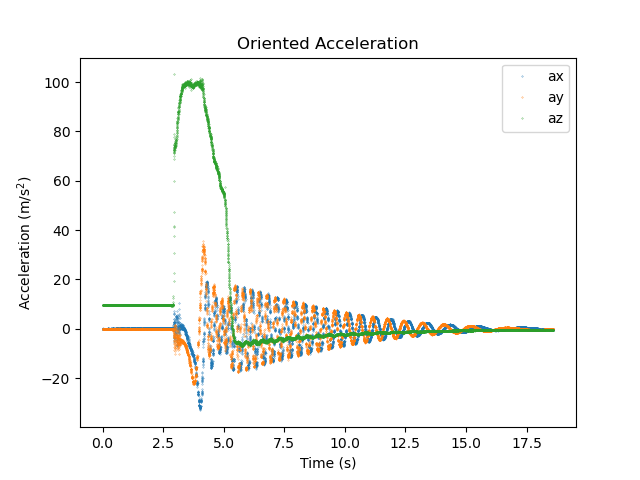

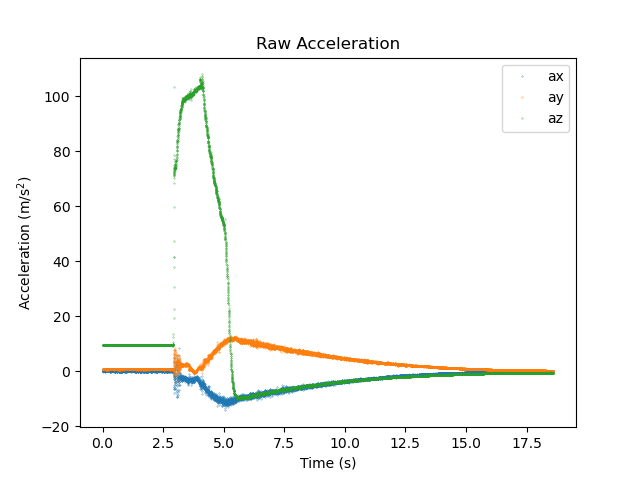

In [8]:
plt.figure()
plt.plot(t[1:],[a[0] for a in acc_plot],'.',markersize=.5, label='ax')
plt.plot(t[1:],[a[1] for a in acc_plot],'.',markersize=.5, label='ay')
plt.plot(t[1:],[a[2] for a in acc_plot],'.',markersize=.5, label='az')
plt.legend()
plt.title('Oriented Acceleration')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration (m/s$^2$)')


plt.figure()
plt.plot(t,ax,'.',markersize=.5, label='ax')
plt.plot(t,ay,'.',markersize=.5, label='ay')
plt.plot(t,az,'.',markersize=.5, label='az')
plt.legend()
plt.title('Raw Acceleration')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration (m/s$^2$)')


In [9]:
i_0 = 1400
a_0 = np.array([spline_ax(fine_t)[:i_0], spline_ay(fine_t)[:i_0], spline_az(fine_t)[:i_0]]).transpose().mean(axis=0)
a_0x, a_0y, a_0z = a_0
a_0xz = np.sqrt(a_0x**2 + a_0z**2)
a_0yz = np.sqrt(a_0y**2 + a_0z**2)
X = np.arcsin(a_0y/a_0yz) 
Y = -np.arccos(a_0z/a_0xz)
g_loc = np.sqrt(a_0x**2 + a_0y**2 + a_0z**2)


In [16]:
filtered_SDS = []
fine_dt = [.002]*len(fine_t)
for i,ts in enumerate(fine_t):
    filtered_SDS.append([np.array([spline_ax(ts), spline_ay(ts), spline_az(ts)]), np.array([spline_gx(ts), spline_gy(ts), spline_gz(ts)])])
acc_plot = []

def update_state(state, state_r, dt):
    pos, vel, ori= state
    acc_r, gyr_r = state_r

    g_acc = np.array([0, 0, g_loc])
    rot_matrix = quaternion.as_rotation_matrix(ori)
    acc = np.dot(rot_matrix, acc_r)
    
    acc_plot.append(acc)
    acc = acc - g_acc

    pos_new = pos + vel * dt + 0.5 * acc * dt**2
    vel_new = vel + acc * dt

    quat_w = quaternion.from_float_array(np.array([np.cos(np.linalg.norm(gyr_r * dt)/2), *np.sin(np.linalg.norm(gyr_r * dt)/2) * (gyr_r * dt)/np.linalg.norm(gyr_r * dt)]))
    ori_new = (quat_w * ori).normalized()

    state_new = [pos_new, vel_new, ori_new]
    return state_new


pos = np.array([0.,0.,0.])  # initial position (x, y, z)
vel = np.array([0.,0.,0.])  # initial velocity (m/s)
ori = quaternion.from_rotation_vector([X, Y, 0])
print("Initial orientation:", ori)
init_state = [[pos, vel, ori]]

def full_trajectory(state_r, dt, state=init_state):
    for i,t in enumerate(dt):
        state.append(update_state(state[i], state_r[i], t))
    return state

state = full_trajectory(filtered_SDS, fine_dt)
positions = np.array([row[0] for row in state])
print('Max altitude:', np.max(positions, axis=0)[2])


Initial orientation: quaternion(0.999266839446064, 0.0382850397278044, -0.000198283924754938, 0)
Max altitude: 1325.284638426436


Text(0, 0.5, 'Acceleration (m/s$^2$)')

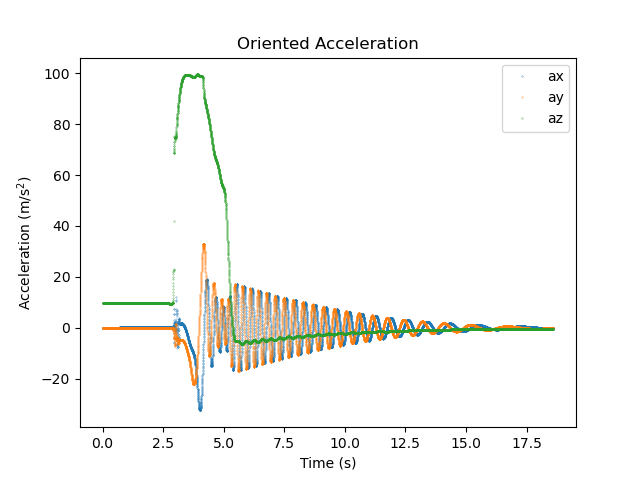

In [17]:
plt.figure()
plt.plot(fine_t,[a[0] for a in acc_plot],'.',markersize=.5, label='ax')
plt.plot(fine_t,[a[1] for a in acc_plot],'.',markersize=.5, label='ay')
plt.plot(fine_t,[a[2] for a in acc_plot],'.',markersize=.5, label='az')
plt.legend()
plt.title('Oriented Acceleration')
plt.xlabel('Time (s)')
plt.ylabel(r'Acceleration (m/s$^2$)')


In [12]:
def set_axes_equal(positions, ax):

    x_limits = [np.min(positions[:, 0]), np.max(positions[:, 0])]
    y_limits = [np.min(positions[:, 1]), np.max(positions[:, 1])]
    z_limits = [np.min(positions[:, 2]), np.max(positions[:, 2])]

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = .75* max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

    axis = [[0, 0, 0, 1, 0, 0],[0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]]
    colors = ['r', 'g', 'b']
    Labels = ['X', 'Y', 'Z']
    for i in range(3):
        ax.quiver(*axis[i], color=colors[i], label = Labels[i], arrow_length_ratio = 0.5, length= plot_radius/5)
    ax.legend()

    

interactive(children=(IntSlider(value=0, description='azim', max=360, step=10), IntSlider(value=10, descriptio…

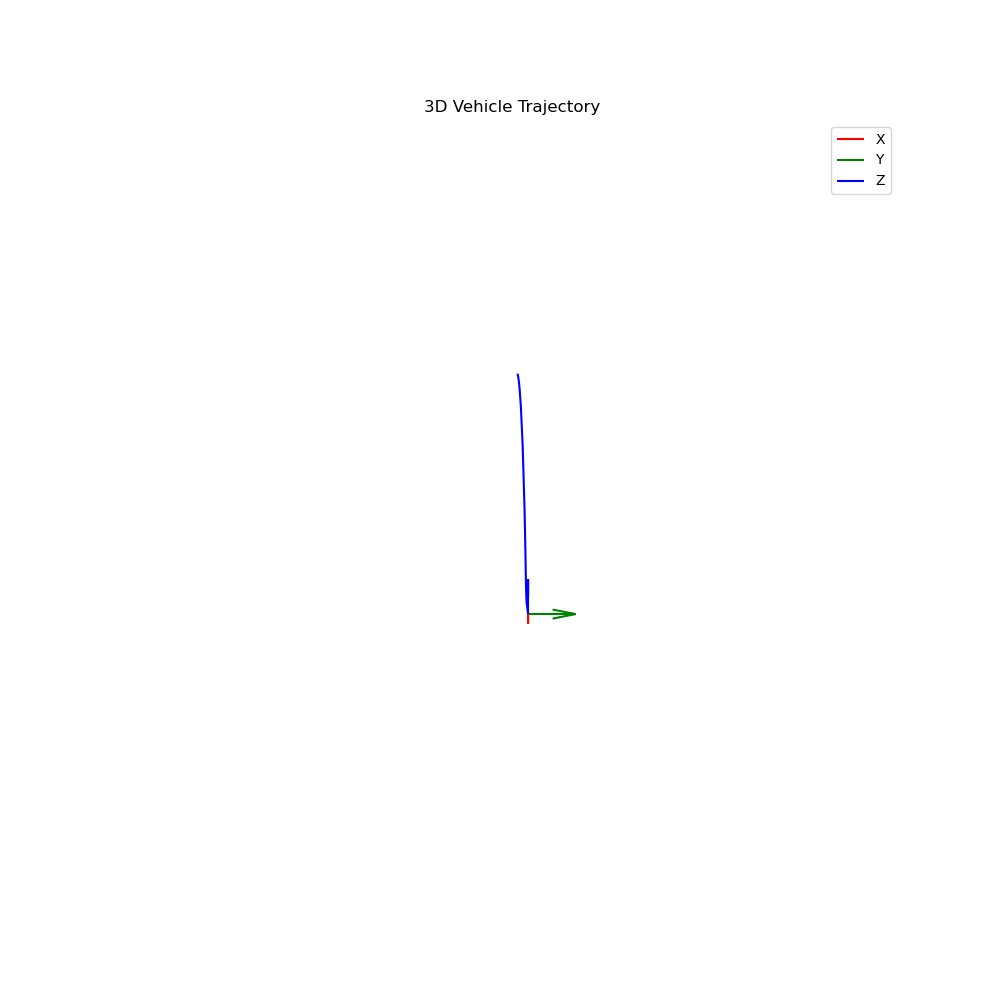

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Y Position (m)')
ax.set_zlabel('Z Position (m)')
ax.set_title('3D Vehicle Trajectory')
plt.axis('off')

set_axes_equal(positions, ax)
 
@widgets.interact(azim=(0, 360, 10), elev=(-90, 90, 10))
def update(azim = 0, elev=10):
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],label='Trajectory', color='blue')
    ax.view_init(elev= elev, azim = azim)
    